# UNet character detector

This competition has 2 tasks:
* detection
* classification  

Here I do only detection. Classification is made further in the same way as MNIST.  
For this purpose I need to predict **not only centers** of characters, but also **bounding boxes**.  

UNet is utilized here to predict two binary masks:  
1) Bounding boxes  
2) Centers  

The example prediction is in the picture

*Bounding rectangles can intersect*.  
This is why I needed center points.  
I used smth like voronoi polygons (right picture) to split characters.  

This gives **~97% f1** score on detection (without classification).  

Classification is made with a separate MNIST-like model.  

### Feel free to ask questions and upvote if you like! :)

References:  
* https://github.com/milesial/Pytorch-UNet
* https://github.com/usuyama/pytorch-unet

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# print(os.listdir('../input/'))
# print(os.listdir('../input/kuzushiji-recognition/'))

# Any results you write to the current directory are saved as output.

In [2]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from skimage import io, transform

# Score
This is taken from official github https://gist.github.com/SohierDane/a90ef46d79808fe3afc70c80bae45972  
I modified the score function so that it evaluates **only detection**, not classification  
Only one line is changed

In [3]:
import sys
sys.path.append("..")
from kuzushiji.classify_character import classify
from kuzushiji.utils.score import detection_f1, kuzushiji_f1

In [4]:
df_train = pd.read_csv('../input/train.csv')
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('../input/unicode_translation.csv').values}
unicode_vocab = sorted(list(unicode_map))
unicode2id = {codepoint: i for (i, codepoint) in enumerate(unicode_vocab)}

df_train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


# Image transform functions

In [5]:
import cv2

IMG_SIZE = 400
BATCH_SIZE = 4

def load_image(path):
    img = cv2.imread(path)
    #img = io.imread(path)
    img = img / 255.
    return img

def coords_to_square(coords, shape):
    new = []
    w, h = shape[:2]
    for x, y in coords:
        if h > w:
            y = int(np.round(y * IMG_SIZE / h))
            x = x + (h - w) / 2
            x = int(np.round(x * IMG_SIZE / h))
        else:
            x = int(np.round(x * IMG_SIZE / w))
            y = y + (w - h) / 2
            y = int(np.round(y * IMG_SIZE / w))
        new.append([x, y])
    return np.array(new)

def to_square(img, img_size=IMG_SIZE):
    three_d = len(img.shape) == 3
    if three_d:
        w, h, c = img.shape
    else:
        w, h = img.shape
        c = 1
    if w > h:
        h = int(h * img_size / w)
        w = img_size
    else:
        w = int(w * img_size / h)
        h = img_size
    img = cv2.resize(img, (h, w), interpolation=cv2.INTER_NEAREST).reshape([w, h, c])
    margin_w = (img_size - w) // 2
    margin_h = (img_size - h) // 2
    new_img = np.zeros((img_size, img_size, c))
    new_img[margin_w: margin_w + w, margin_h: margin_h + h, :] = img
    if not three_d:
        new_img = new_img.reshape([img_size, img_size])
    return new_img.astype('float32')

def unsquare(img, width, height, coords=None):
    if coords is None:
        if width > height:
            w = IMG_SIZE
            h = int(height * IMG_SIZE / width)
        else:
            h = IMG_SIZE
            w = int(width * IMG_SIZE / height)
        margin_w = (IMG_SIZE - w) // 2
        margin_h = (IMG_SIZE - h) // 2
        img = img[margin_w: margin_w + w, margin_h: margin_h + h]
        img = cv2.resize(img, (height, width))
    else:
        [x1, y1], [x2, y2] = coords
        [sx1, sy1], [sx2, sy2] = coords_to_square(coords, [width, height])
        img = cv2.resize(img[sx1: sx2, sy1: sy2], (y2 - y1, x2 - x1))
    return img

def get_mask(img, labels):
    mask = np.zeros((img.shape[0], img.shape[1], 2), dtype='float32')
    if isinstance(labels, str):
        labels = np.array(labels.split(' ')).reshape(-1, 5)
        for char, x, y, w, h in labels:
            x, y, w, h = int(x), int(y), int(w), int(h)
            if x + w >= img.shape[1] or y + h >= img.shape[0]:
                continue
            mask[y: y + h, x: x + w, 0] = 1
            radius = 6
            mask[y + h // 2 - radius: y + h // 2 + radius + 1, x + w // 2 - radius: x + w // 2 + radius + 1, 1] = 1
    return mask

def preprocess(img, width, height):
    skip = 8
    if width > height:
        w = IMG_SIZE
        h = int(height * IMG_SIZE / width)
    else:
        h = IMG_SIZE
        w = int(width * IMG_SIZE / height)
    margin_w = (IMG_SIZE - w) // 2
    margin_h = (IMG_SIZE - h) // 2
    sl_x = slice(margin_w, margin_w + w)
    sl_y = slice(margin_h, margin_h + h)
    stat = img[margin_w:margin_w + w:skip, margin_h:margin_h + h:skip].reshape([-1, 3])
    img[sl_x, sl_y] = img[sl_x, sl_y] - np.median(stat, 0)
    img[sl_x, sl_y] = img[sl_x, sl_y] / np.std(stat, 0)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2836, 1799, 3) (2836, 1799, 2) (400, 400, 3) (2836, 1799, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2998, 1974, 3) (2998, 1974, 2) (400, 400, 3) (2998, 1974, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3200, 2268, 3) (3200, 2268, 2) (400, 400, 3) (3200, 2268, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3238, 2059, 3) (3238, 2059, 2) (400, 400, 3) (3238, 2059, 3)


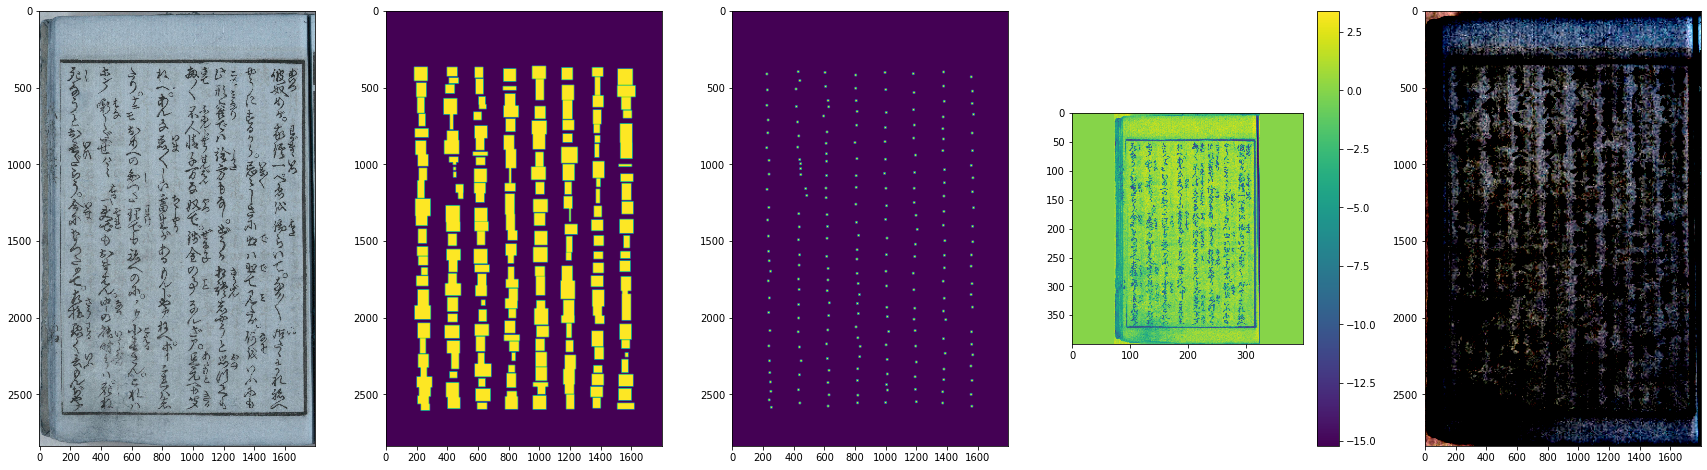

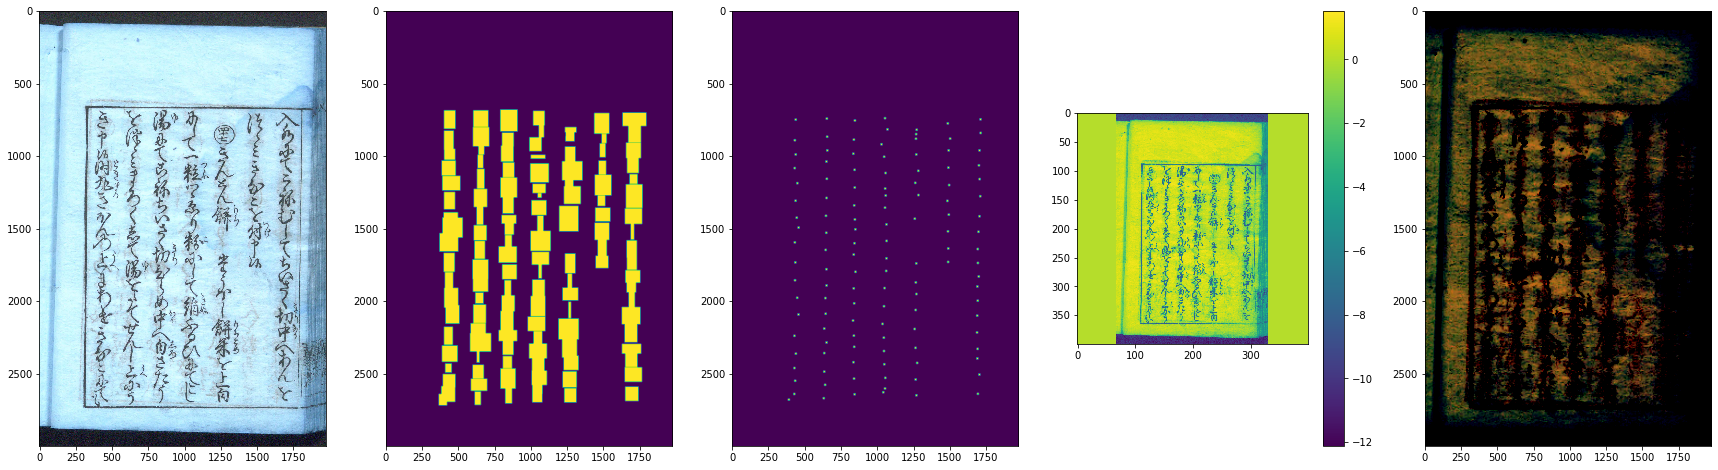

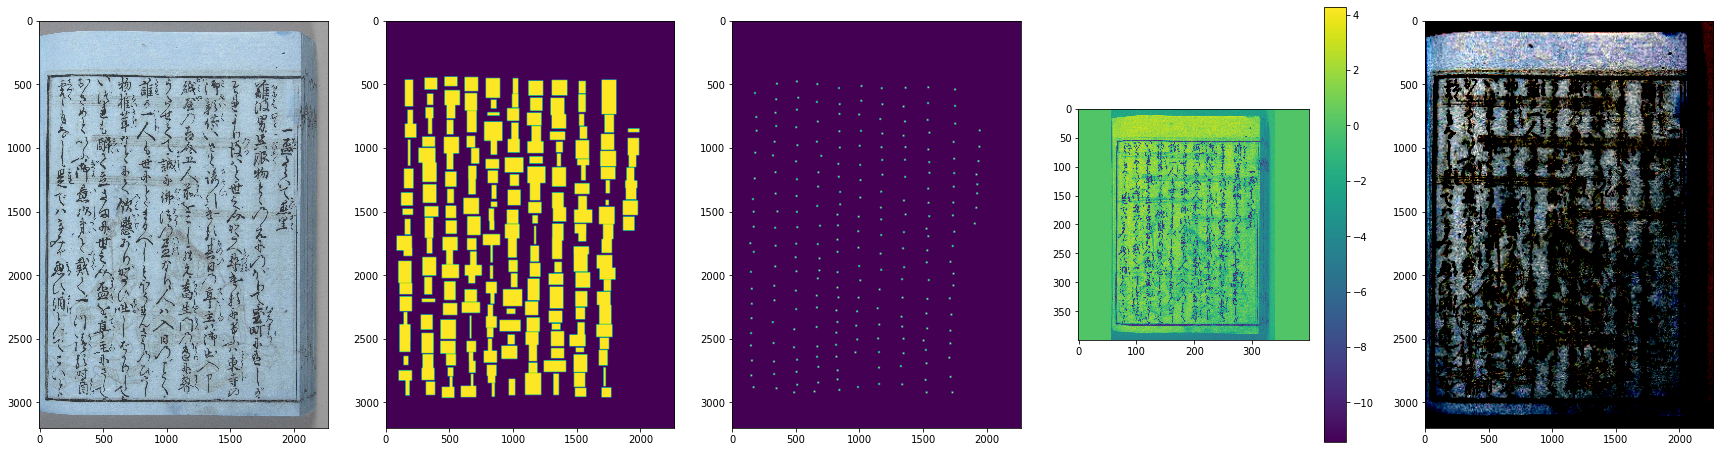

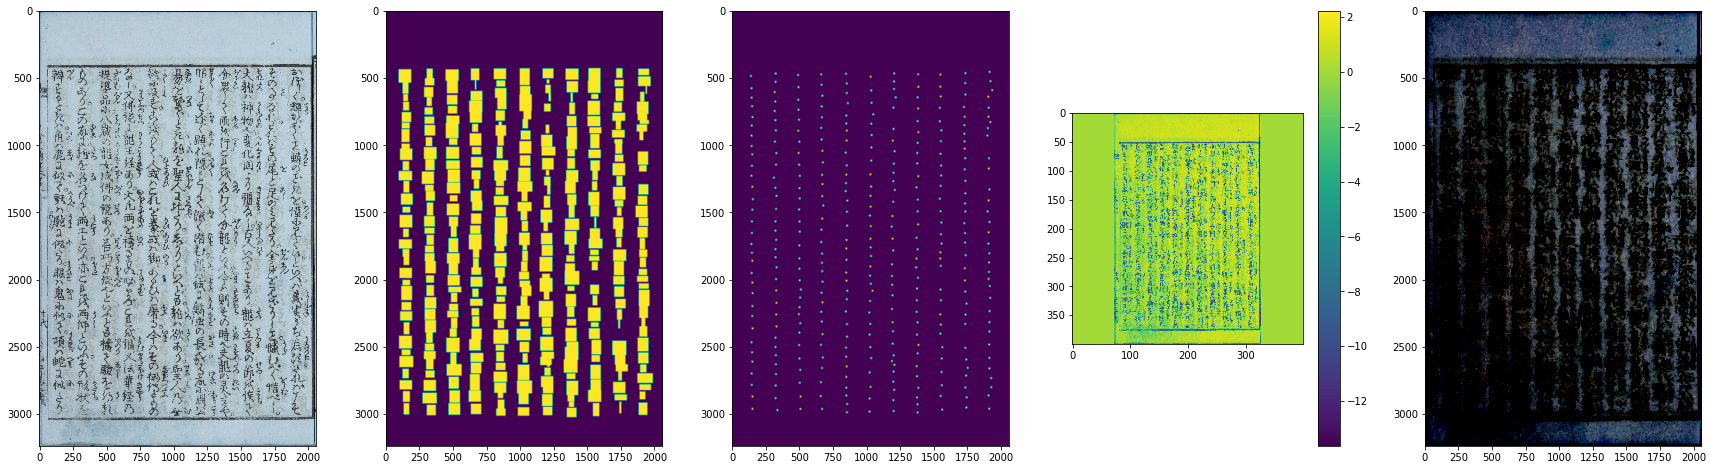

In [6]:
np.random.seed(1337)

for i in range(4):
    idx, labels = df_train.values[np.random.randint(len(df_train))]
    img = load_image('../input/train_images/{}.jpg'.format(idx))
    width, height, _ = img.shape
    mask = get_mask(img, labels)
    img_square = preprocess(to_square(img), img.shape[0], img.shape[1])
    img_unsq = unsquare(img_square, width, height)
    
    print(img.shape, mask.shape, img_square.shape, img_unsq.shape)
    
    fig, axs = plt.subplots(1, 5, figsize=(30, 8))
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :, 0], interpolation='bilinear')
    axs[2].imshow(mask[:, :, 1], interpolation='bilinear')
    pos = axs[3].imshow(img_square.sum(2))
    fig.colorbar(pos, ax=axs[3])
    axs[4].imshow(img_unsq)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data generator for torch models

In [8]:
class PapirusDataset(Dataset):
    """Papirus dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        image = load_image(img_name)
        if self.training:
            mask = get_mask(image, labels)
        shape = np.array(image.shape)[:2]
        
        image = to_square(image)
        image = preprocess(image, shape[0], shape[1])
        if self.training:
            mask = to_square(mask)
        
        image = np.rollaxis(image, 2, 0)
        if self.training:
            mask = np.rollaxis(mask, 2, 0)
        else:
            mask = 0
        
        sample = [image, mask, shape]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

torch.Size([4, 3, 400, 400])


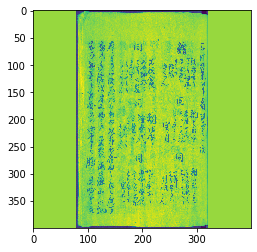

In [9]:
for batch in DataLoader(PapirusDataset(df_train, '../input/train_images/{}.jpg'),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4):
    print(batch[0].shape)
    plt.imshow(batch[0][0].sum(0))
    break

# Define model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    '''https://github.com/milesial/Pytorch-UNet'''
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(3, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    '''https://github.com/usuyama/pytorch-unet'''
    def __init__(self, n_classes):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())
        
        self.conv_orig0 = inconv(3, 32)
        self.conv_orig1 = double_conv(32, 64)
        
        self.down0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.down1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.down2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.down3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.down4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.up1 = up(512 + 256, 256)
        self.up2 = up(256 + 128, 128)
        self.up3 = up(128 + 64, 64)
        self.up4 = up(64 + 64, 64)
        self.up5 = up(64 + 64, 64)
        #self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x_orig = self.conv_orig0(x)
        x_orig = self.conv_orig1(x_orig)
        
        x1 = self.down0(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.up5(x, x_orig)
        #x = self.upsample(x)
        x = self.outc(x)
        return x

In [11]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] = metrics.get('bce', []) + [bce.data.cpu().numpy()]
    metrics['dice'] = metrics.get('dice', []) + [dice.data.cpu().numpy()]
    metrics['loss'] = metrics.get('loss', []) + [loss.data.cpu().numpy()]

    return loss

# Train

In [12]:
from sklearn.model_selection import train_test_split
from collections import defaultdict
import gc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
def train(model, dataloaders, num_epochs=1):
    history = {'train': [], 'val': []}
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            metrics = {}
            for inputs, labels, shape in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = calc_loss(outputs, labels, metrics)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            history[phase].append({k: np.mean(metrics[k]) for k in metrics})
            print(phase, history[phase][-1])
    return model, history

In [14]:
xy_train, xy_dev = train_test_split(df_train, test_size=0.01)

dataloaders = {'train': DataLoader(PapirusDataset(xy_train, '../input/train_images/{}.jpg'),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=8),
              'val': DataLoader(PapirusDataset(xy_dev, '../input/train_images/{}.jpg'),
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=8)}

In [15]:
# %%time

# torch.cuda.empty_cache()
# gc.collect()

# model = MyUNet(n_classes=2)
# model = model.to(device)

# torch.cuda.empty_cache()
# gc.collect()

# num_epochs = 20
# model, history = train(model, dataloaders, num_epochs)

In [16]:
# torch.save(model.state_dict(), '../cache/detector_model.pth')

# history_tr = pd.DataFrame({'train_' + k: [metrics[k] for metrics in history['train']] for k in history['train'][0]})
# history_val = pd.DataFrame({'val_' + k: [metrics[k] for metrics in history['val']] for k in history['val'][0]})
# df_history = pd.concat([history_tr, history_val], 1)
# fig = plt.figure(figsize=(12, 6))
# ax = plt.axes()
# df_history.plot(ax=ax)
# df_history

# Make predictions on validation set

In [17]:
torch.cuda.empty_cache()

try:
    type(model)
except:
    model = MyUNet(n_classes=2)
    model = model.to(device)
    model.load_state_dict(torch.load("../cache/detector_model.pth"))

model.eval()
print('load model done')

load model done


In [18]:
from sklearn.cluster import KMeans

def get_centers(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    centers = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M['m00'] > 0:
            cy = M['m10'] / M['m00']
            cx = M['m01'] / M['m00']
        else:
            cy, cx = cnt[0][0]
        cx = int(np.round(cx))
        cy = int(np.round(cy))
        centers.append([cx, cy])
    centers = np.array(centers)
    return centers

def get_labels(centers, shape):
    if len(centers) == 0:
        return
    kmeans = KMeans(len(centers), init=centers)
    kmeans.fit(centers)
    coords = []
    mlt = 2
    for i in range(0, shape[0], mlt):
        coords.append([])
        for j in range(0, shape[1], mlt):
            coords[-1].append([i, j])
    coords = np.array(coords).reshape([-1, 2])
    preds = kmeans.predict(coords)
    preds = preds.reshape([shape[0] // mlt, shape[1] // mlt])
    labels = np.zeros(shape, dtype='int')
    for k in range(mlt):
        labels[k::mlt, k::mlt] = preds
    return labels

def get_voronoi(centers, mask):
    labels = get_labels(centers, mask.shape)
    colors = np.random.uniform(0, 1, size=[len(centers), 3])
    voronoi = colors[labels]
    voronoi *= mask[:, :, None]
    return voronoi

def get_rectangles(centers, mask):
    mask_sq = to_square(mask)
    centers_sq = coords_to_square(centers, mask.shape)
    labels_sq = get_labels(centers_sq, mask_sq.shape)
    rects = [None for _ in centers]
    valid_centers = []
    for i, (xc, yc) in enumerate(centers):
        msk = (labels_sq == i).astype('float') * mask_sq / mask_sq.max()
        # crop msk
        max_size = 400
        x1 = max(0, int(np.round(xc - max_size // 2)))
        y1 = max(0, int(np.round(yc - max_size // 2)))
        x2 = min(mask.shape[0], int(np.round(xc + max_size // 2)))
        y2 = min(mask.shape[1], int(np.round(yc + max_size // 2)))
        msk = unsquare(msk, mask.shape[0], mask.shape[1], coords=[[x1,y1], [x2, y2]])
        msk = cv2.inRange(msk, 0.5, 10000)
        contours, _ = cv2.findContours(msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for cnt in contours:
            y, x, h, w = cv2.boundingRect(cnt)
            x += x1
            y += y1
            if xc >= x and xc <= x + w and yc >= y and yc <= y + h:
                rects[i] = [x, y, w, h]
                if cv2.contourArea(cnt) <= h * w * 0.66:
                    rad_x = min(xc - x, x + w - xc)
                    rad_y = min(yc - y, y + h - yc)
                    rects[i] = [int(np.round(xc - rad_x)), y, int(np.round(2 * rad_x)), h]
                break
        if rects[i] is not None:
            valid_centers.append([xc, yc])
    return np.array([r for r in rects if r is not None]), np.array(valid_centers)

def draw_rectangles(img, rects, centers, fill_rect=[1, 0, 0], fill_cent=[1, 0, 0], fill_all=False):
    new = np.array(img)
    for x, y, w, h in rects:
        for shift in range(4):
            try:
                if fill_all:
                    new[x: x + w, y: y + h] = fill_rect
                else:
                    new[x: x + w, y + shift] = fill_rect
                    new[x: x + w, y + h - shift] = fill_rect
                    new[x + shift, y: y + h] = fill_rect
                    new[x + w - shift, y: y + h] = fill_rect
            except:
                pass
    for x, y in centers:
        r = 15
        new[x - r: x + r, y - r: y + r] = fill_cent
    return new

def add_skipped(mask, boxes, centers):
    avg_w = np.mean([b[2] for b in boxes])
    avg_area = np.mean([b[2] * b[3] for b in boxes])
    new_centers, new_boxes = [], []
    mask_c = draw_rectangles(mask, boxes, [], 0, fill_all=True)
    contours, _ = cv2.findContours(mask_c, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        y, x, h, w = cv2.boundingRect(cnt)
        found = False
        for xc, yc in centers:
            if xc >= x and xc <= x + w and yc >= y and yc <= y + h:
                found = True
                break
        if not found and (w * h > avg_area * 0.66 or w > avg_w * 1.5):
            new_centers.append([x + w // 2, y + h // 2])
            new_boxes.append([x, y, w, h])
    if len(new_centers) > 0:
        boxes = np.concatenate([boxes, new_boxes], 0)
        centers = np.concatenate([centers, new_centers], 0)
    return boxes, centers

In [19]:
def detect_char(dataframe, image_location):
    pred_boxes = []
    pred_centers = []

    dataloaders = {'data': DataLoader(PapirusDataset(dataframe, image_location, training=False),
                            batch_size=4,
                            shuffle=False,
                            num_workers=8)}
    gc.collect()

    for inputs, labels, shape in tqdm(dataloaders['data']):
        inputs = inputs.to(device)
        outputs = model(inputs)

        for i in range(len(inputs.data.cpu().numpy())):
            img = inputs.data.cpu().numpy()[i]
            mask = outputs.data.cpu().numpy()[i]
            shp = shape.data.cpu().numpy()[i]

            binary0 = cv2.inRange(unsquare(mask[0], shp[0], shp[1]), 0.0, 10000)
            binary1 = cv2.inRange(unsquare(mask[1], shp[0], shp[1]), 0.0, 10000)

            centers0 = get_centers(binary1)
            rects, centers = get_rectangles(centers0, binary0)
            rects, centers = add_skipped(binary0, rects, centers)

            cnts = []
            for x, y in centers:
                cnts += ['unk', str(y), str(x)]
            cnts = None if len(cnts) == 0 else ' '.join(cnts)
            pred_centers.append(cnts)

            boxes = []
            for x, y, w, h in rects:
                boxes += ['unk', str(y), str(x), str(h), str(w)]
            boxes = None if len(boxes) == 0 else ' '.join(boxes)
            pred_boxes.append(boxes)

    predictions_center = pd.DataFrame({'image_id': dataframe['image_id'], 'labels': pred_centers})
    predictions_box = pd.DataFrame({'image_id': dataframe['image_id'], 'labels': pred_boxes})

    return predictions_center, predictions_box

In [20]:
def classify_char(dataframe, centers_df, boxes_df, image_location):
    image_indices = []
    predictions = []
    true_predictions = []
    for i in tqdm(range(dataframe.shape[0])):
        image_id = dataframe.iloc[i]["image_id"]
        image_indices.append(image_id)
        if boxes_df.iloc[i]['labels'] is None or boxes_df.iloc[i]['labels'] is np.nan:
            predictions.append(None)
            true_predictions.append(None)
            continue
        labels = boxes_df.iloc[i]["labels"].split(" ")
        boxes = []
        for j in range(0, len(labels), 5):
            x = int(labels[j+1])
            y = int(labels[j+2])
            w = int(labels[j+3])
            h = int(labels[j+4])
            boxes.append((x, y, w, h))
        image = Image.open(image_location.format(image_id))
        results = classify(image, boxes)
        
        centers = centers_df.loc[centers_df.image_id == image_id]['labels'].iloc[0]
        centers = np.array(centers.split(" ")).reshape(-1, 3)
        pred = []
        true_pred = []
        for j in range(len(results)):
            center_x = centers[j][1]
            center_y = centers[j][2]
            pred += [results[j], str(center_x), str(center_y)]
            true_pred += [results[j], str(boxes[j][0]), str(boxes[j][1]), str(boxes[j][2]), str(boxes[j][3])]
        pred = ' '.join(pred)
        true_pred = ' '.join(true_pred)
        predictions.append(pred)
        true_predictions.append(true_pred)
    predictions_result = pd.DataFrame({'image_id': image_indices, 'labels': predictions})
    true_predictions_box = pd.DataFrame({'image_id': image_indices, 'labels': true_predictions})
    return predictions_result, true_predictions_box

## Validation data

In [21]:
image_loc = '../input/train_images/{}.jpg'
# val_centers, val_boxes = detect_char(xy_dev, image_loc)
# val_centers.to_csv('../cache/val_centers.csv', index=False)
# val_boxes.to_csv('../cache/val_boxes.csv', index=False)

In [22]:
val_centers = pd.read_csv('../cache/val_centers.csv')
val_boxes = pd.read_csv('../cache/val_boxes.csv')

detection_f1(val_centers, xy_dev)

precision: 0.9657601803578977 recall: 0.9478633660627852


0.9567280848687884

In [23]:
torch.cuda.empty_cache()
gc.collect()

42819

In [26]:
val_result, val_true_result = classify_char(xy_dev, val_centers, val_boxes, image_loc)
val_result.to_csv('../cache/val_result.csv', index=False)
val_true_result.to_csv('../cache/val_true_result.csv', index=False)

In [27]:
val_result = pd.read_csv('../cache/val_result.csv')

kuzushiji_f1(val_result, xy_dev)

precision: 0.6714709622721492 recall: 0.6571705158346011


0.6642437797036622

In [28]:
torch.cuda.empty_cache()
gc.collect()

3

## Train data

In [43]:
# image_loc = '../input/train_images/{}.jpg'
# # train_centers, train_boxes = detect_char(df_train, image_loc)
# # train_centers.to_csv('../cache/train_centers.csv', index=False)
# # train_boxes.to_csv('../cache/train_boxes.csv', index=False)

In [44]:
# train_centers = pd.read_csv('../cache/train_centers.csv')
# train_boxes = pd.read_csv('../cache/train_boxes.csv')

# detection_f1(train_centers, df_train)

precision: 0.9605148160479441 recall: 0.9455055423548278


0.9529510826928409

In [45]:
# torch.cuda.empty_cache()
# gc.collect()

80

In [46]:
# train_result, train_true_result = classify_char(df_train, train_centers, train_boxes, image_loc)
# train_result.to_csv('../cache/train_result.csv', index=False)
# train_true_result.to_csv('../cache/train_true_result.csv', index=False)

In [47]:
# train_result = pd.read_csv('../cache/train_result.csv')
# train_true_result = pd.read_csv('../cache/train_true_result.csv')

# kuzushiji_f1(train_result, df_train)

precision: 0.43270160279743647 recall: 0.4243851907342596


0.4285030492128776

In [48]:
# torch.cuda.empty_cache()
# gc.collect()

0

## Test data

In [34]:
image_loc = '../input/test_images/{}.jpg'
submission_df = pd.read_csv('../input/sample_submission.csv')
sub_centers, sub_boxes = detect_char(submission_df, image_loc)
sub_centers.to_csv('../cache/sub_centers.csv', index=False)
sub_boxes.to_csv('../cache/sub_boxes.csv', index=False)

In [35]:
torch.cuda.empty_cache()
gc.collect()

11

In [36]:
submission_result, _ = classify_char(submission_df, sub_centers, sub_boxes, image_loc)
submission_result.to_csv('../cache/submission_result2.csv', index=False)